# UE Localization Pipeline: Visualization Presentation

This notebook generates high-quality visualizations for the UE Localization pipeline, demonstrating:
1. **Input Features**: The radio measurements (RT, PHY, MAC) encoded by the model.
2. **Map Layers**: The multi-channel Radio and OSM maps used for context.
3. **Model Predictions**: The Gaussian Mixture Model (GMM) output overlaid on the ground truth.

In [29]:
import sys
import os
from pathlib import Path
import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import importlib

# Get the absolute path to project root
project_root = Path("/home/ubuntu/projects/CellularPositioningResearch")

print(f"Project root: {project_root}")
print(f"Current working directory: {os.getcwd()}")

# Change to project root
os.chdir(project_root)
print(f"Changed to: {os.getcwd()}")

# Add src to path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Force deep reload of all src modules by removing them from cache first
to_remove = [key for key in sys.modules.keys() if key.startswith('src.')]
for key in to_remove:
    del sys.modules[key]

from src.training import UELocalizationLightning
from src.datasets.radio_dataset import collate_fn

# Set aesthetic style
plt.style.use('seaborn-v0_8-paper')
sns.set_context("talk")

Project root: /home/ubuntu/projects/CellularPositioningResearch
Current working directory: /home/ubuntu/projects/CellularPositioningResearch
Changed to: /home/ubuntu/projects/CellularPositioningResearch


## 1. Load Model and Data

We load the trained model from a checkpoint. We patch the configuration to point to a valid dataset for visualization.

In [30]:
# Configuration
CHECKPOINT_PATH = "checkpoints/quick_test/last.ckpt"
BASE_CONFIG_PATH = "checkpoints/quick_test/training_config.yaml"

# Find a valid dataset
PROCESSED_DATA_DIR = Path("data/processed/sionna_dataset")
possible_datasets = sorted(list(PROCESSED_DATA_DIR.glob("dataset_*.zarr")))
if possible_datasets:
    DATASET_PATH = str(possible_datasets[-1]) # Use latest
    print(f"Using dataset: {DATASET_PATH}")
else:
    # Fallback
    DATASET_PATH = "data/processed/sionna_dataset_eval/dataset_eval.zarr"

if not os.path.exists(CHECKPOINT_PATH):
    print(f"Warning: Checkpoint {CHECKPOINT_PATH} not found.")
    # Try to find any checkpoint
    ckpts = list(Path("checkpoints").rglob("*.ckpt"))
    if ckpts:
        CHECKPOINT_PATH = str(ckpts[0])
        print(f"Fallback to: {CHECKPOINT_PATH}")

# Patch Config
try:
    with open(BASE_CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
    
    print(f"Patching dataset path in config to: {DATASET_PATH}")
    config['dataset']['train_zarr_paths'] = [DATASET_PATH]
    if 'test_zarr_path' in config['dataset']:
        config['dataset']['test_zarr_path'] = DATASET_PATH
    if 'val_zarr_path' in config['dataset']:
        config['dataset']['val_zarr_path'] = DATASET_PATH
    
    TEMP_CONFIG_PATH = "notebooks/temp_viz_config.yaml"
    with open(TEMP_CONFIG_PATH, 'w') as f:
        yaml.dump(config, f)

    # Load Model
    print(f"Loading model from: {CHECKPOINT_PATH}")
    model = UELocalizationLightning.load_from_checkpoint(
        CHECKPOINT_PATH, 
        config_path=TEMP_CONFIG_PATH,
        strict=False # Allow minor mismatches
    )
    model.eval()
    model.cuda() if torch.cuda.is_available() else model.cpu()

finally:
    if os.path.exists(TEMP_CONFIG_PATH):
        os.remove(TEMP_CONFIG_PATH)

# Setup Data
# We manually setup the dataloader from the config in the checkpoint
val_loader = model.val_dataloader()

# Skip a few batches to get samples with more varied positions
# (First batches often have positions near trajectory start)
batch_iter = iter(val_loader)
for _ in range(5):  # Skip first 5 batches to get more diverse positions
    batch = next(batch_iter)

# Move batch to device
device = model.device
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)
    elif isinstance(v, dict):
        for sub_k, sub_v in v.items():
            if isinstance(sub_v, torch.Tensor):
                v[sub_k] = sub_v.to(device)

# Show position distribution in this batch
positions = batch['position'].cpu().numpy()
print(f"Loaded batch with {positions.shape[0]} samples")
print(f"Position range in batch: X=[{positions[:,0].min():.3f}, {positions[:,0].max():.3f}], Y=[{positions[:,1].min():.3f}, {positions[:,1].max():.3f}]")

Using dataset: data/processed/sionna_dataset/dataset_20260106_121828.zarr
Patching dataset path in config to: data/processed/sionna_dataset/dataset_20260106_121828.zarr
Loading model from: checkpoints/quick_test/last.ckpt


/home/ubuntu/projects/CellularPositioningResearch/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Loaded batch with 8 samples
Position range in batch: X=[0.110, 0.110], Y=[0.011, 0.011]


## 2. Visualize Input Features

We extract the raw radio measurements for a single sample in the batch. These features (RT, PHY, MAC) are what the model uses to localize the UE.

In [32]:
def visualize_features(batch, sample_idx=0):
    measurements = batch['measurements']
    
    # Extract data for the sample
    mask = measurements['mask'][sample_idx].cpu().numpy()
    seq_len = int(mask.sum())  # Only take valid steps
    
    data = {
        'Time': measurements['timestamps'][sample_idx, :seq_len].cpu().numpy(),
        'Cell ID': measurements['cell_ids'][sample_idx, :seq_len].cpu().numpy(),
        'Beam ID': measurements['beam_ids'][sample_idx, :seq_len].cpu().numpy(),
        'Path Gain (dB)': measurements['rt_features'][sample_idx, :seq_len, 0].cpu().numpy(),
        'ToA (ns)': measurements['rt_features'][sample_idx, :seq_len, 1].cpu().numpy(),
        'SNR (dB)': measurements['phy_features'][sample_idx, :seq_len, 2].cpu().numpy(),
        'SINR (dB)': measurements['phy_features'][sample_idx, :seq_len, 3].cpu().numpy(),
        'Throughput (Mbps)': measurements['mac_features'][sample_idx, :seq_len, 0].cpu().numpy(),
    }
    
    df = pd.DataFrame(data)
    
    # Styling
    print(f"Input Feature Sequence (Sample {sample_idx})")
    styled = df.style.background_gradient(cmap='viridis', subset=['Path Gain (dB)', 'SNR (dB)', 'Throughput (Mbps)'])
    display(styled)
    
    return df

_ = visualize_features(batch, sample_idx=0)

Input Feature Sequence (Sample 0)


,Time,Cell ID,Beam ID,Path Gain (dB),ToA (ns),SNR (dB),SINR (dB),Throughput (Mbps)
0,0.000000,0,0,2.645238,0.014270,3.496366,-0.258160,-0.002113


## 3. Visualize Map Layers

The model conditions on multi-channel maps of the environment. Here we visualize the Radio Map (Signal propagation) and the OSM Map (Physical environment).

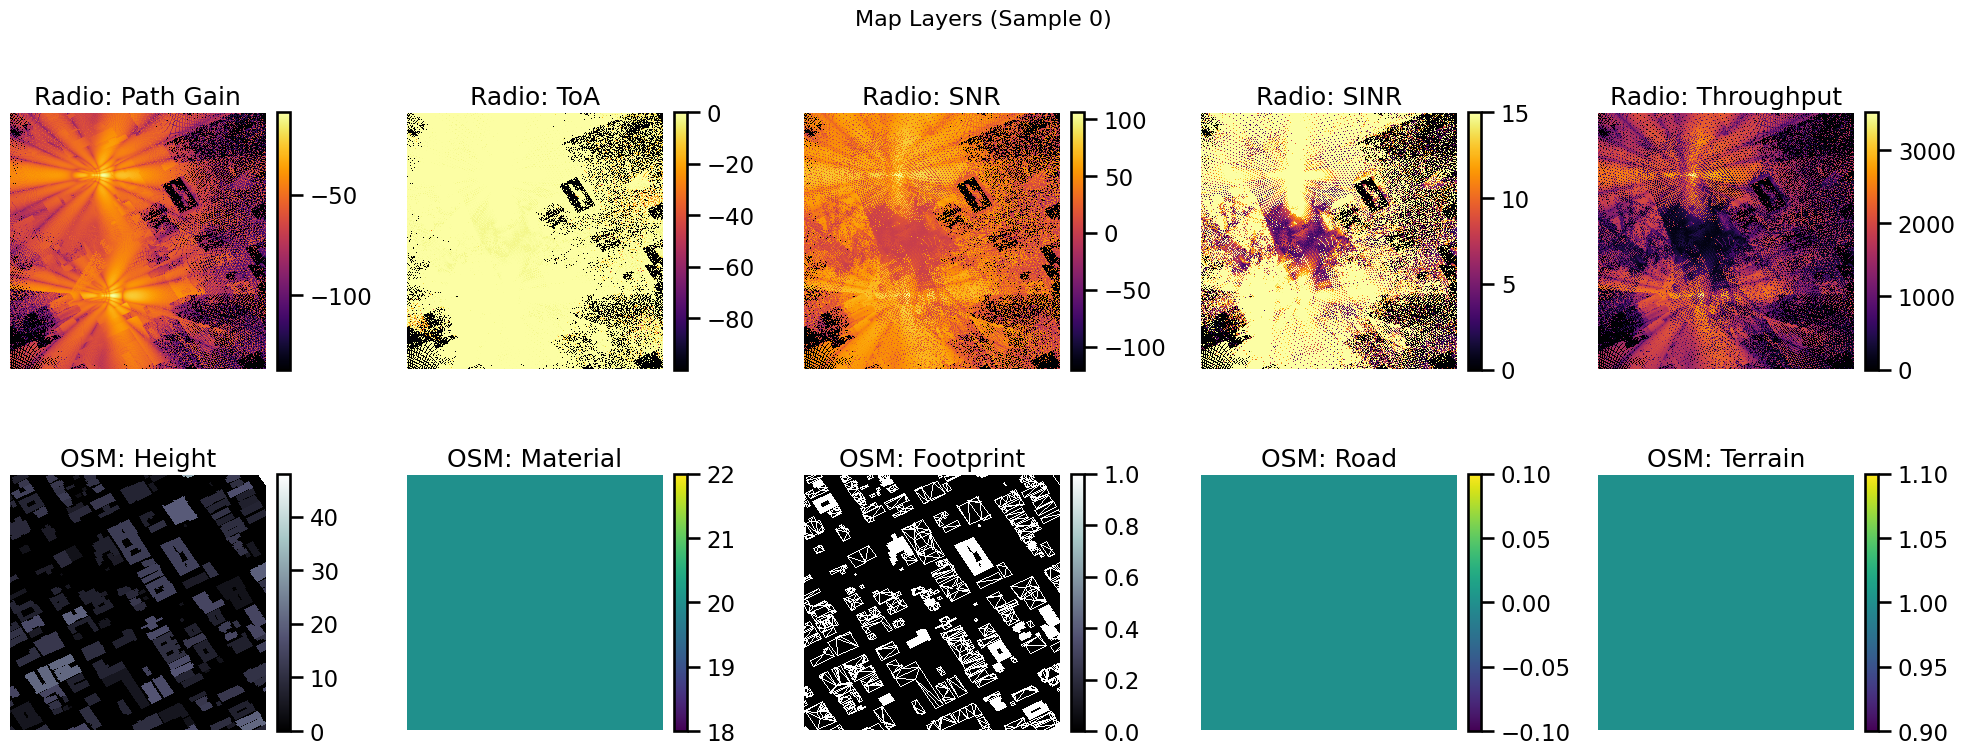

In [33]:
def visualize_maps(batch, sample_idx=0):
    radio_map = batch['radio_map'][sample_idx].cpu().numpy()
    osm_map = batch['osm_map'][sample_idx].cpu().numpy()
    
    # Radio Map Channels: ['Path Gain', 'ToA', 'SNR', 'SINR', 'Throughput']
    # OSM Map Channels: ['Height', 'Material', 'Footprint', 'Road', 'Terrain']
    # Note: Material (1), Road (3), Terrain (4) are often constant/empty but included for compat
    
    num_osm_channels = osm_map.shape[0]
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    # Plot Radio Maps
    radio_titles = ['Path Gain', 'ToA', 'SNR', 'SINR', 'Throughput']
    for i in range(5):
        im = axes[0, i].imshow(radio_map[i], cmap='inferno')
        axes[0, i].set_title(f"Radio: {radio_titles[i]}")
        axes[0, i].axis('off')
        plt.colorbar(im, ax=axes[0, i], fraction=0.046, pad=0.04)

    # Plot OSM Maps (all 5 channels for backward compatibility)
    osm_titles = ['Height', 'Material', 'Footprint', 'Road', 'Terrain']
    for i in range(min(num_osm_channels, 5)):
        cmap = 'bone' if i in [0, 2] else 'viridis'
        im = axes[1, i].imshow(osm_map[i], cmap=cmap)
        axes[1, i].set_title(f"OSM: {osm_titles[i]}")
        axes[1, i].axis('off')
        plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)
    
    # Hide unused subplot axes if fewer channels
    for i in range(num_osm_channels, 5):
        axes[1, i].axis('off')
        axes[1, i].set_title("(Not Used)")
    
    plt.suptitle(f"Map Layers (Sample {sample_idx})", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_maps(batch)

## 4. Model Predictions vs Ground Truth

Finally, we run the model and visualize the predicted **Gaussian Mixture Model (GMM)** representing the probability distribution of the user's location. We overlay this on the map along with the true position.

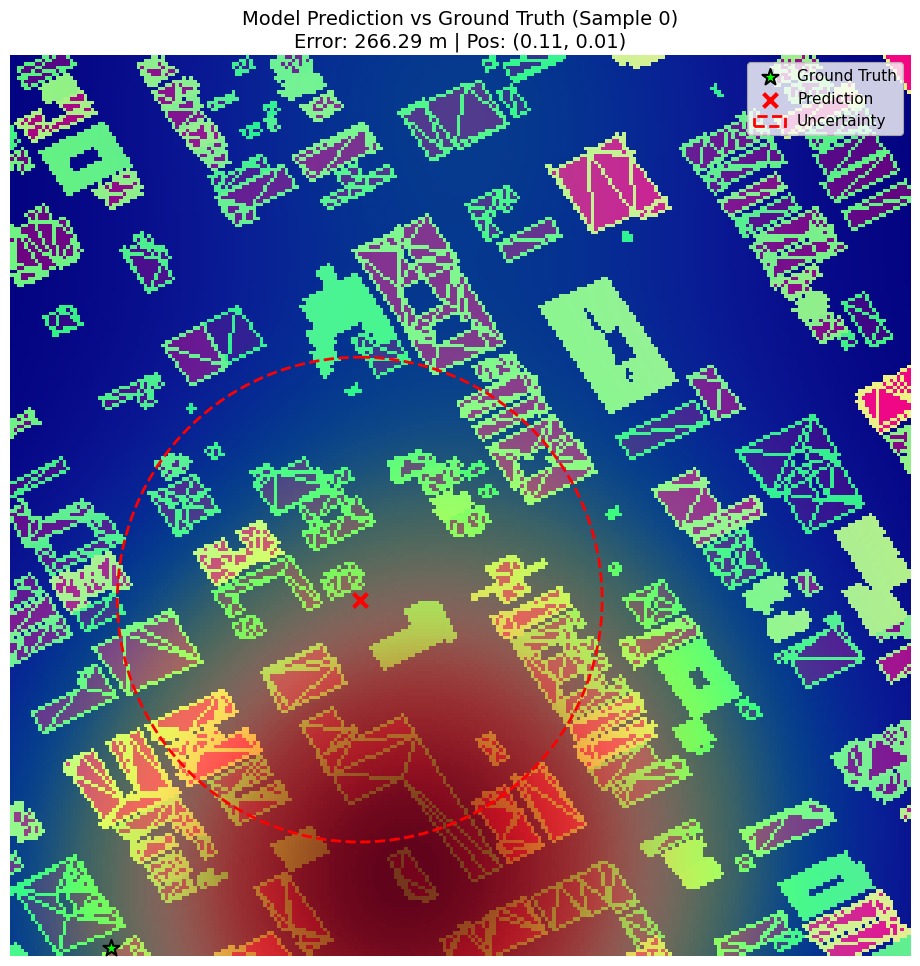

In [34]:
def render_prediction(model, batch, sample_idx=0):
    with torch.no_grad():
        # Use the model's internal model (UELocalizationModel) directly
        outputs = model.model(batch['measurements'], batch['radio_map'], batch['osm_map'])
    
    # Extract outputs for sample
    top_k_indices = outputs['top_k_indices'][sample_idx]
    top_k_probs = outputs['top_k_probs'][sample_idx]
    fine_offsets = outputs['fine_offsets'][sample_idx]
    fine_uncertainties = outputs['fine_uncertainties'][sample_idx]
    pred_pos = outputs['predicted_position'][sample_idx].cpu().numpy()
    true_pos = batch['position'][sample_idx].cpu().numpy()
    
    # Get map dimensions
    h, w = batch['radio_map'].shape[-2:]
    grid_size = model.model.grid_size
    
    # Render GMM Heatmap manually using model's coarse head
    gmm_heatmap = np.zeros((h, w), dtype=np.float32)
    
    # For each top-K component, render a gaussian
    for k in range(min(5, len(top_k_indices))):
        cell_idx = top_k_indices[k].item()
        prob = top_k_probs[k].item()
        offset = fine_offsets[k].cpu().numpy()
        sigma = fine_uncertainties[k].cpu().numpy()  # [σx, σy]
        
        # Cell center (in normalized coords [0, 1])
        cell_x = (cell_idx % grid_size) / grid_size + 0.5 / grid_size
        cell_y = (cell_idx // grid_size) / grid_size + 0.5 / grid_size
        
        # Add offset (clamped to valid range)
        center_x = np.clip(cell_x + offset[0], 0, 1)
        center_y = np.clip(cell_y + offset[1], 0, 1)
        
        # Convert to pixel coordinates
        # Note: Flip Y because image coords have (0,0) at top-left, but position coords have (0,0) at bottom-left
        cx_px = center_x * w
        cy_px = (1 - center_y) * h  # FLIP Y for image coordinates
        
        # Scale sigma to pixels
        sigma_px = np.abs(sigma) * w + 1e-3
        
        # Create coordinate grids
        y_grid, x_grid = np.ogrid[:h, :w]
        
        # Compute Gaussian
        gauss = np.exp(-0.5 * ((x_grid - cx_px) / sigma_px[0])**2 
                       -0.5 * ((y_grid - cy_px) / sigma_px[1])**2)
        gmm_heatmap += prob * gauss
    
    # Normalize heatmap
    if gmm_heatmap.max() > 0:
        gmm_heatmap /= gmm_heatmap.max()
    
    # Prepare visualization
    # Background: OSM channels - supports both 5-channel (old) and 2-channel (new) formats
    osm_map = batch['osm_map'][sample_idx].cpu().numpy()
    bg = np.zeros((h, w, 3))
    bg[..., 0] = model._normalize_map(osm_map[0])  # Height (R)
    
    # Handle both old (5-channel) and new (2-channel) OSM formats
    if osm_map.shape[0] >= 5:
        # Old format: [Height, Material, Footprint, Road, Terrain]
        bg[..., 1] = model._normalize_map(osm_map[2])  # Footprint (G)
        bg[..., 2] = model._normalize_map(osm_map[3] + osm_map[4] * 0.5)  # Road+Terrain (B)
    elif osm_map.shape[0] >= 2:
        # New format: [Height, Footprint]
        bg[..., 1] = model._normalize_map(osm_map[1])  # Footprint (G)
        bg[..., 2] = 0
    
    # GMM Overlay
    gmm_colored = plt.cm.turbo(gmm_heatmap)
    gmm_colored[..., 3] = np.clip(gmm_heatmap * 0.8, 0, 0.8) # Alpha
    
    # Coordinates (convert normalized [0,1] to pixel coords)
    # IMPORTANT: Flip Y axis - position (0,0) is bottom-left, image (0,0) is top-left
    true_px = true_pos[0] * w
    true_py = (1 - true_pos[1]) * h  # FLIP Y for image coordinates
    pred_px = pred_pos[0] * w
    pred_py = (1 - pred_pos[1]) * h  # FLIP Y for image coordinates
    
    # Compute error in meters (using actual scene extent if available)
    scene_extent = batch['sample_extent'][sample_idx].item() if 'sample_extent' in batch else 512.0
    error_m = np.linalg.norm((true_pos - pred_pos) * scene_extent)
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(bg)
    plt.imshow(gmm_colored)
    
    plt.scatter([true_px], [true_py], c='lime', s=150, marker='*', label='Ground Truth', edgecolors='black', zorder=10, linewidth=1.5)
    plt.scatter([pred_px], [pred_py], c='red', s=100, marker='x', label='Prediction', linewidth=3, zorder=10)
    
    # Add uncertainty ellipse (from first component)
    sigma = fine_uncertainties[0].cpu().numpy()
    sigma_px = np.abs(sigma) * w
    circle = plt.Circle((pred_px, pred_py), sigma_px.mean(), color='red', fill=False, linestyle='--', label='Uncertainty', linewidth=2)
    plt.gca().add_patch(circle)

    plt.title(f"Model Prediction vs Ground Truth (Sample {sample_idx})\nError: {error_m:.2f} m | Pos: ({true_pos[0]:.2f}, {true_pos[1]:.2f})", fontsize=14)
    plt.legend(loc='upper right', fontsize=11)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return outputs

# Use a sample with position more in the center for better visualization
# Sample 0 is often at corner of trajectory
outputs = render_prediction(model, batch, sample_idx=0)

## 5. Evaluation Metrics

We compute the key localization metrics used to evaluate the model:
- **Median Error**: 50th percentile of position errors (meters)
- **RMSE**: Root Mean Square Error
- **67th/90th Percentile**: FCC-style accuracy metrics
- **CDF Curves**: Cumulative distribution of errors

In [35]:
def compute_evaluation_metrics(model, batch, scene_extent=512.0):
    """Compute comprehensive evaluation metrics for the batch."""
    with torch.no_grad():
        outputs = model.model(batch['measurements'], batch['radio_map'], batch['osm_map'])
    
    pred_pos = outputs['predicted_position'].cpu().numpy()  # [B, 2] normalized
    true_pos = batch['position'].cpu().numpy()  # [B, 2] normalized
    
    # Convert to meters
    errors_m = np.linalg.norm((pred_pos - true_pos) * scene_extent, axis=1)
    
    metrics = {
        'Mean Error (m)': np.mean(errors_m),
        'Median Error (m)': np.median(errors_m),
        'RMSE (m)': np.sqrt(np.mean(errors_m**2)),
        'Std Error (m)': np.std(errors_m),
        '67th Percentile (m)': np.percentile(errors_m, 67),
        '90th Percentile (m)': np.percentile(errors_m, 90),
        '95th Percentile (m)': np.percentile(errors_m, 95),
        'Max Error (m)': np.max(errors_m),
        'Min Error (m)': np.min(errors_m),
    }
    
    return metrics, errors_m, pred_pos, true_pos

# Compute metrics
metrics, errors_m, pred_pos, true_pos = compute_evaluation_metrics(model, batch)

# Display metrics
print("=" * 50)
print("EVALUATION METRICS")
print("=" * 50)
for key, value in metrics.items():
    print(f"  {key:25s}: {value:8.3f}")
print("=" * 50)

EVALUATION METRICS
  Mean Error (m)           :  243.387
  Median Error (m)         :  243.387
  RMSE (m)                 :  243.387
  Std Error (m)            :    0.011
  67th Percentile (m)      :  243.393
  90th Percentile (m)      :  243.400
  95th Percentile (m)      :  243.402
  Max Error (m)            :  243.403
  Min Error (m)            :  243.371


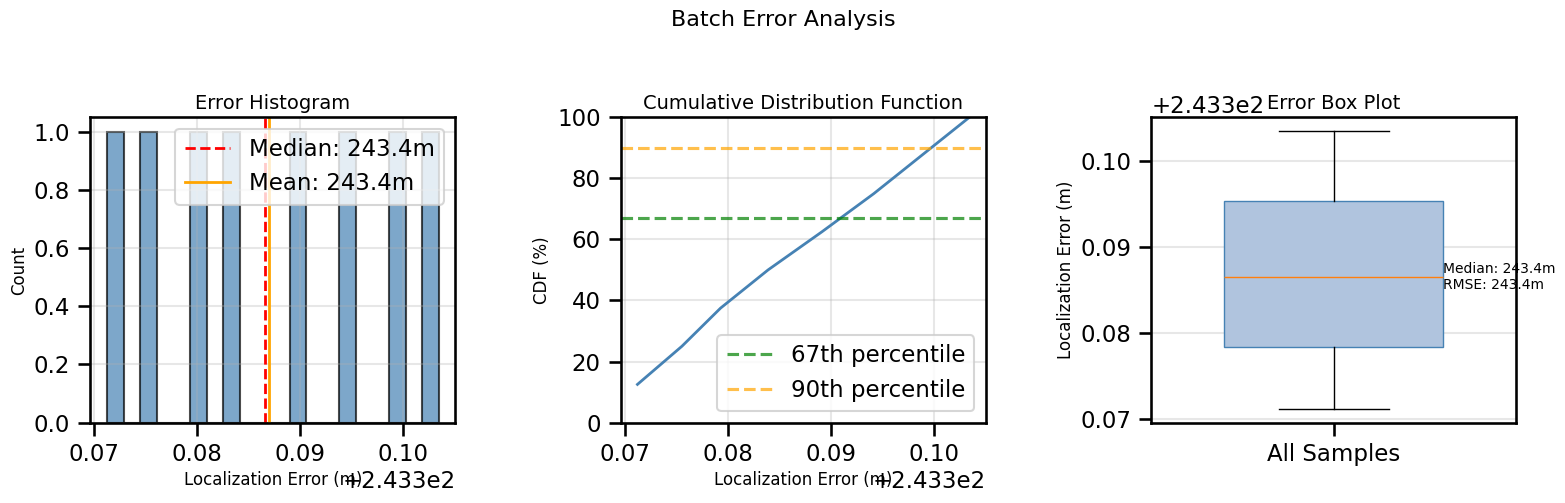

In [36]:
def plot_error_analysis(errors_m, title="Error Distribution"):
    """Plot comprehensive error analysis visualizations."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Histogram of errors
    ax = axes[0]
    ax.hist(errors_m, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(np.median(errors_m), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(errors_m):.1f}m')
    ax.axvline(np.mean(errors_m), color='orange', linestyle='-', linewidth=2, label=f'Mean: {np.mean(errors_m):.1f}m')
    ax.set_xlabel('Localization Error (m)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Error Histogram', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. CDF Plot
    ax = axes[1]
    sorted_errors = np.sort(errors_m)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    ax.plot(sorted_errors, cdf * 100, linewidth=2, color='steelblue')
    ax.axhline(67, color='green', linestyle='--', alpha=0.7, label='67th percentile')
    ax.axhline(90, color='orange', linestyle='--', alpha=0.7, label='90th percentile')
    ax.set_xlabel('Localization Error (m)', fontsize=12)
    ax.set_ylabel('CDF (%)', fontsize=12)
    ax.set_title('Cumulative Distribution Function', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 100])
    
    # 3. Box Plot
    ax = axes[2]
    bp = ax.boxplot(errors_m, vert=True, widths=0.6, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightsteelblue')
    bp['boxes'][0].set_edgecolor('steelblue')
    ax.set_ylabel('Localization Error (m)', fontsize=12)
    ax.set_title('Error Box Plot', fontsize=14)
    ax.set_xticks([1])
    ax.set_xticklabels(['All Samples'])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistics text
    stats_text = f"Median: {np.median(errors_m):.1f}m\nRMSE: {np.sqrt(np.mean(errors_m**2)):.1f}m"
    ax.text(1.3, np.median(errors_m), stats_text, fontsize=10, verticalalignment='center')
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot error analysis for the batch
plot_error_analysis(errors_m, "Batch Error Analysis")

## 6. Coarse and Fine Loss Decomposition

The model uses a **coarse-to-fine** approach with two loss components:
- **Coarse Loss**: Cross-entropy over grid cells - learns to identify the correct region
- **Fine Loss**: Mixture Negative Log-Likelihood - refines position within top-K cells

$$\mathcal{L}_{\text{total}} = \lambda_{\text{coarse}} \mathcal{L}_{\text{coarse}} + \lambda_{\text{fine}} \mathcal{L}_{\text{fine}}$$

LOSS BREAKDOWN
  Total Loss:         8.2000
  Coarse Loss (CE):   7.3234
  Fine Loss (NLL):    0.8767


/tmp/ipykernel_1042515/1117683587.py:83: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


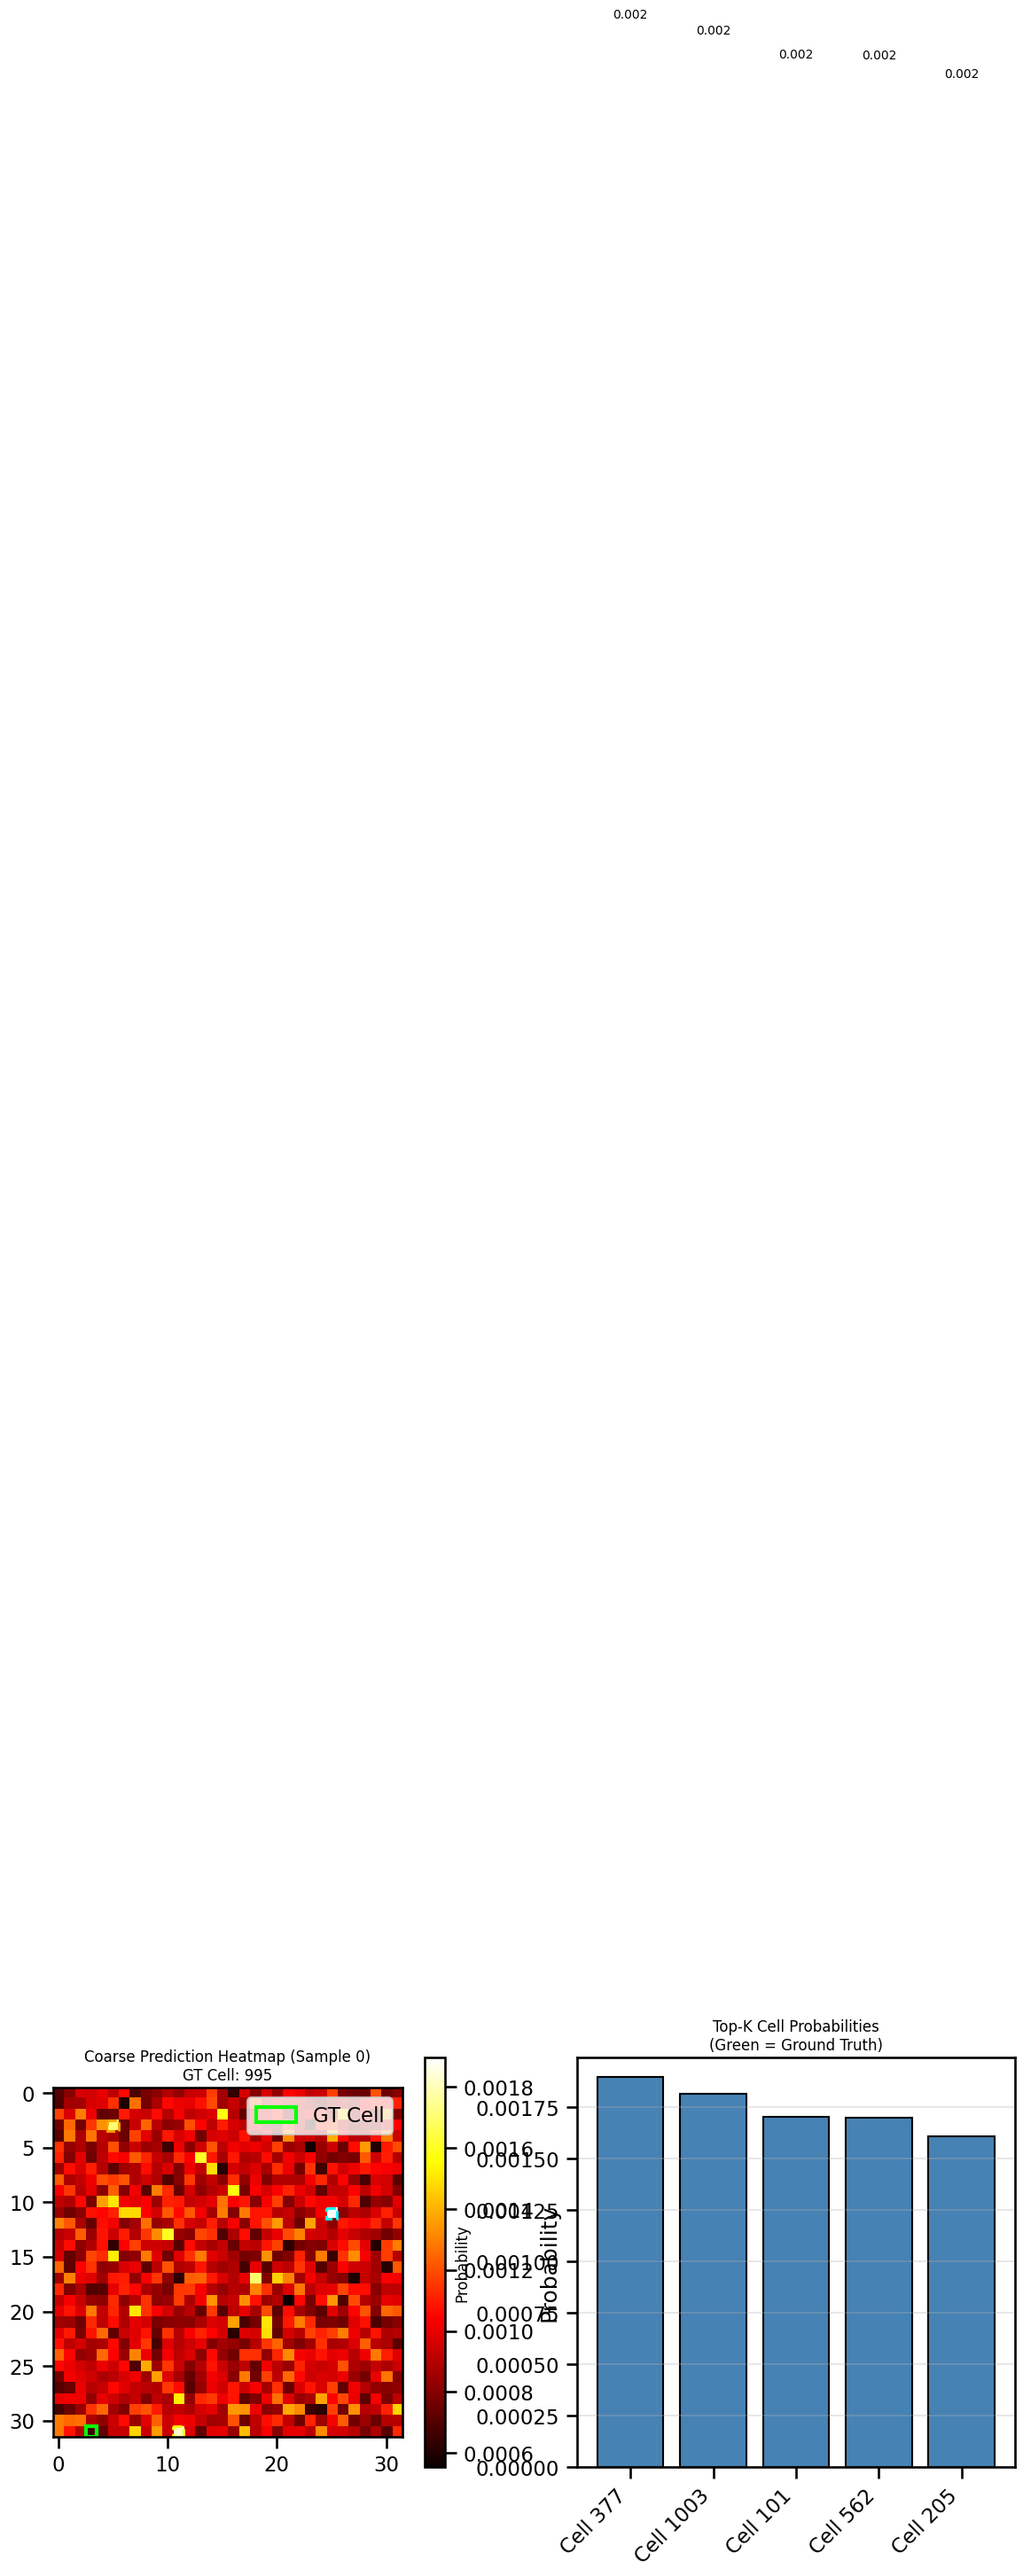

In [37]:
def compute_loss_breakdown(model, batch):
    """Compute and visualize the coarse and fine loss components."""
    with torch.no_grad():
        outputs = model.model(batch['measurements'], batch['radio_map'], batch['osm_map'])
    
    targets = {
        'position': batch['position'],
        'cell_grid': batch['cell_grid'],
    }
    
    loss_weights = {'coarse_weight': 1.0, 'fine_weight': 1.0}
    losses = model.model.compute_loss(outputs, targets, loss_weights)
    
    return losses, outputs

losses, outputs = compute_loss_breakdown(model, batch)

# Display loss breakdown
print("=" * 50)
print("LOSS BREAKDOWN")
print("=" * 50)
print(f"  Total Loss:         {losses['loss'].item():.4f}")
print(f"  Coarse Loss (CE):   {losses['coarse_loss'].item():.4f}")
print(f"  Fine Loss (NLL):    {losses['fine_loss'].item():.4f}")
print("=" * 50)

# Visualize the coarse heatmap for a sample
def visualize_coarse_heatmap(outputs, batch, sample_idx=0):
    """Visualize the coarse prediction heatmap and ground truth cell."""
    coarse_heatmap = outputs['coarse_heatmap'][sample_idx].cpu().numpy()
    true_pos = batch['position'][sample_idx].cpu().numpy()
    true_cell = batch['cell_grid'][sample_idx].item()
    
    grid_size = int(np.sqrt(coarse_heatmap.shape[0])) if coarse_heatmap.ndim == 1 else coarse_heatmap.shape[0]
    
    # Ensure heatmap is 2D
    if coarse_heatmap.ndim == 1:
        coarse_heatmap = coarse_heatmap.reshape(grid_size, grid_size)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Coarse heatmap with true position
    ax = axes[0]
    im = ax.imshow(coarse_heatmap, cmap='hot', interpolation='nearest')
    
    # Mark ground truth cell
    gt_y, gt_x = true_cell // grid_size, true_cell % grid_size
    rect = plt.Rectangle((gt_x - 0.5, gt_y - 0.5), 1, 1, fill=False, edgecolor='lime', linewidth=3, label='GT Cell')
    ax.add_patch(rect)
    
    # Mark top-K cells
    top_k_indices = outputs['top_k_indices'][sample_idx].cpu().numpy()
    top_k_probs = outputs['top_k_probs'][sample_idx].cpu().numpy()
    for k, (idx, prob) in enumerate(zip(top_k_indices[:3], top_k_probs[:3])):
        ky, kx = idx // grid_size, idx % grid_size
        color = ['cyan', 'yellow', 'orange'][k]
        rect = plt.Rectangle((kx - 0.5, ky - 0.5), 1, 1, fill=False, edgecolor=color, linewidth=2, linestyle='--')
        ax.add_patch(rect)
    
    ax.set_title(f'Coarse Prediction Heatmap (Sample {sample_idx})\nGT Cell: {true_cell}', fontsize=12)
    plt.colorbar(im, ax=ax, label='Probability')
    ax.legend(loc='upper right')
    
    # 2. Top-K probabilities bar chart
    ax = axes[1]
    top_k = 5
    indices = top_k_indices[:top_k]
    probs = top_k_probs[:top_k]
    
    colors = ['green' if idx == true_cell else 'steelblue' for idx in indices]
    bars = ax.bar(range(top_k), probs, color=colors, edgecolor='black')
    ax.set_xticks(range(top_k))
    ax.set_xticklabels([f'Cell {idx}' for idx in indices], rotation=45, ha='right')
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_title('Top-K Cell Probabilities\n(Green = Ground Truth)', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Annotate bars
    for i, (bar, prob) in enumerate(zip(bars, probs)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

visualize_coarse_heatmap(outputs, batch)

## 7. Fine Refinement Head Analysis

The **Fine Head** outputs:
1. **Offsets**: Sub-cell displacements $(\Delta x, \Delta y)$ from cell centers
2. **Uncertainties**: Predicted standard deviations $(\sigma_x, \sigma_y)$ per component

The final position combines the coarse cell center with the fine offset:
$$\hat{\mathbf{y}} = \text{CellCenter}(c^*) + \Delta\mathbf{y}$$

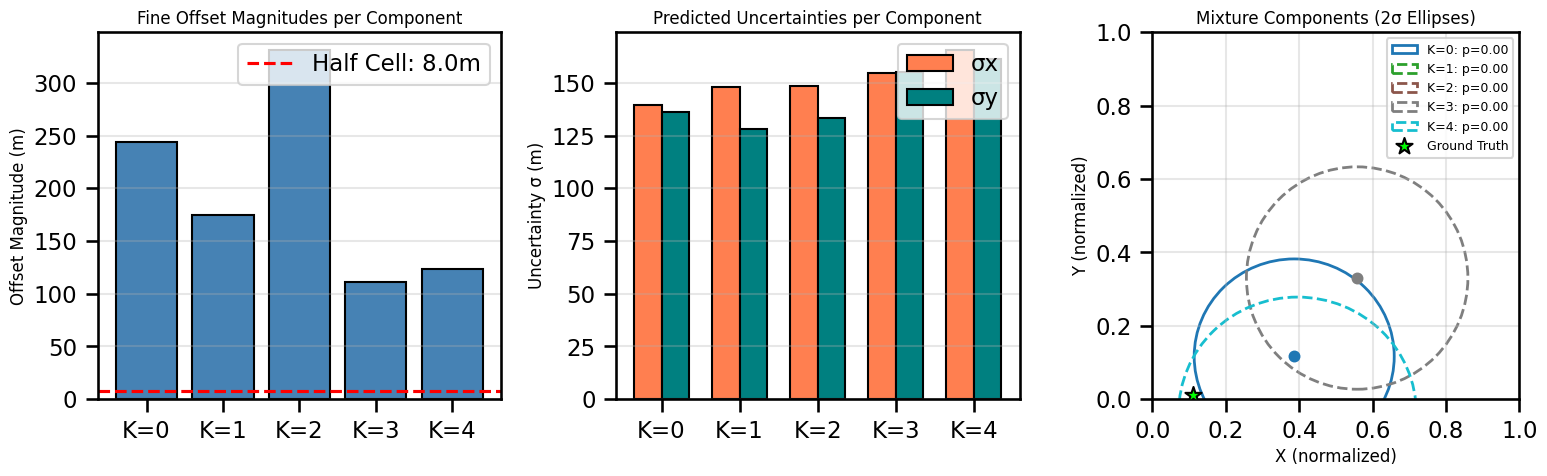

In [38]:
def visualize_fine_refinement(outputs, batch, sample_idx=0, scene_extent=512.0):
    """Visualize the fine refinement outputs (offsets and uncertainties)."""
    fine_offsets = outputs['fine_offsets'][sample_idx].cpu().numpy()  # [K, 2]
    fine_uncertainties = outputs['fine_uncertainties'][sample_idx].cpu().numpy()  # [K, 2]
    top_k_indices = outputs['top_k_indices'][sample_idx].cpu().numpy()
    top_k_probs = outputs['top_k_probs'][sample_idx].cpu().numpy()
    true_pos = batch['position'][sample_idx].cpu().numpy()
    
    grid_size = model.model.grid_size
    cell_size = 1.0 / grid_size  # Normalized cell size
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Offset magnitudes for each component
    ax = axes[0]
    offset_magnitudes = np.linalg.norm(fine_offsets, axis=1) * scene_extent  # in meters
    bars = ax.bar(range(len(offset_magnitudes)), offset_magnitudes, color='steelblue', edgecolor='black')
    ax.set_xticks(range(len(offset_magnitudes)))
    ax.set_xticklabels([f'K={i}' for i in range(len(offset_magnitudes))])
    ax.set_ylabel('Offset Magnitude (m)', fontsize=12)
    ax.set_title('Fine Offset Magnitudes per Component', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(cell_size * scene_extent / 2, color='red', linestyle='--', label=f'Half Cell: {cell_size*scene_extent/2:.1f}m')
    ax.legend()
    
    # 2. Uncertainty (sigma) for each component
    ax = axes[1]
    sigma_x = fine_uncertainties[:, 0] * scene_extent
    sigma_y = fine_uncertainties[:, 1] * scene_extent
    x = np.arange(len(sigma_x))
    width = 0.35
    ax.bar(x - width/2, sigma_x, width, label='σx', color='coral', edgecolor='black')
    ax.bar(x + width/2, sigma_y, width, label='σy', color='teal', edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels([f'K={i}' for i in range(len(sigma_x))])
    ax.set_ylabel('Uncertainty σ (m)', fontsize=12)
    ax.set_title('Predicted Uncertainties per Component', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Visualize mixture components on a zoomed view
    ax = axes[2]
    
    # Plot each mixture component as an ellipse
    from matplotlib.patches import Ellipse
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_k_indices)))
    for k, (idx, prob, offset, sigma, color) in enumerate(zip(top_k_indices, top_k_probs, fine_offsets, fine_uncertainties, colors)):
        # Cell center (normalized)
        cx = (idx % grid_size + 0.5) * cell_size
        cy = (idx // grid_size + 0.5) * cell_size
        
        # Apply offset
        px = cx + offset[0]
        py = cy + offset[1]
        
        # Draw ellipse (2-sigma)
        ellipse = Ellipse((px, py), 2 * sigma[0], 2 * sigma[1], 
                          fill=False, edgecolor=color, linewidth=2, 
                          linestyle='-' if k == 0 else '--',
                          label=f'K={k}: p={prob:.2f}')
        ax.add_patch(ellipse)
        ax.scatter(px, py, c=[color], s=50, marker='o', zorder=5)
    
    # Mark true position
    ax.scatter(true_pos[0], true_pos[1], c='lime', s=150, marker='*', 
               edgecolors='black', zorder=10, label='Ground Truth')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')
    ax.set_xlabel('X (normalized)', fontsize=12)
    ax.set_ylabel('Y (normalized)', fontsize=12)
    ax.set_title('Mixture Components (2σ Ellipses)', fontsize=12)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_fine_refinement(outputs, batch)

## 8. Physics Loss & Differentiable Bilinear Resampling

The **Physics Loss** enforces consistency between predicted positions and observed radio measurements using precomputed radio maps. This is accomplished via **differentiable bilinear interpolation** using `F.grid_sample`.

$$\mathcal{L}_{\text{phys}} = \sum_{f \in \mathcal{F}} w_f \left\| m_f^{\text{obs}} - R_f(\hat{\mathbf{x}}) \right\|^2$$

Where:
- $R_f(\hat{\mathbf{x}})$ = Bilinear interpolation of feature $f$ from the radio map at predicted position $\hat{\mathbf{x}}$
- $m_f^{\text{obs}}$ = Observed feature from measurements
- $w_f$ = Feature weight (path_gain: 1.0, SNR: 0.8, SINR: 0.8, etc.)

In [39]:
from src.physics_loss import differentiable_lookup, normalize_coords, PhysicsLoss, PhysicsLossConfig

def demonstrate_bilinear_resampling(batch, sample_idx=0):
    """Demonstrate differentiable bilinear interpolation from radio maps."""
    radio_map = batch['radio_map'][sample_idx:sample_idx+1]  # [1, C, H, W]
    true_pos = batch['position'][sample_idx:sample_idx+1]  # [1, 2] normalized
    
    # Map extent (normalized coordinates)
    map_extent = (0.0, 0.0, 1.0, 1.0)
    
    # Sample features at true position
    sampled_features = differentiable_lookup(true_pos, radio_map, map_extent)
    
    print("=" * 60)
    print("DIFFERENTIABLE BILINEAR RESAMPLING DEMONSTRATION")
    print("=" * 60)
    print(f"\nTrue Position (normalized): [{true_pos[0, 0].item():.4f}, {true_pos[0, 1].item():.4f}]")
    print(f"Radio Map Shape: {radio_map.shape}")
    print(f"\nSampled Features at True Position:")
    
    feature_names = ['Path Gain', 'ToA', 'AoA', 'SNR', 'SINR']
    for i, (name, val) in enumerate(zip(feature_names, sampled_features[0].cpu().numpy())):
        print(f"  {name:12s}: {val:.4f}")
    
    return sampled_features, radio_map

sampled_features, radio_map_sample = demonstrate_bilinear_resampling(batch)

DIFFERENTIABLE BILINEAR RESAMPLING DEMONSTRATION

True Position (normalized): [0.1103, 0.0107]
Radio Map Shape: torch.Size([1, 5, 256, 256])

Sampled Features at True Position:
  Path Gain   : -112.9076
  ToA         : -67.9396
  AoA         : -66.0450
  SNR         : 4.8047
  SINR        : 515.4883


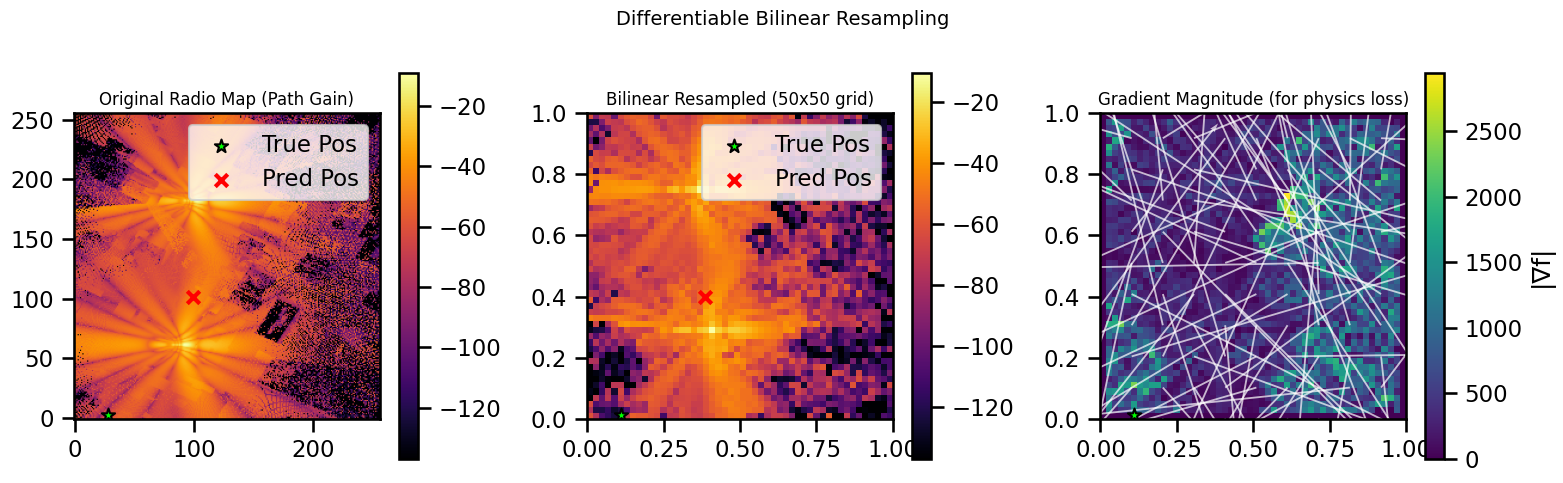

In [40]:
def visualize_bilinear_sampling(batch, sample_idx=0):
    """Visualize the bilinear sampling process on the radio map."""
    radio_map = batch['radio_map'][sample_idx].cpu().numpy()  # [C, H, W]
    true_pos = batch['position'][sample_idx].cpu().numpy()  # [2]
    pred_pos = outputs['predicted_position'][sample_idx].cpu().numpy()
    
    h, w = radio_map.shape[-2:]
    
    # Sample grid of positions
    grid_x = np.linspace(0, 1, 50)
    grid_y = np.linspace(0, 1, 50)
    xx, yy = np.meshgrid(grid_x, grid_y)
    sample_positions = torch.tensor(np.stack([xx.flatten(), yy.flatten()], axis=1), dtype=torch.float32)
    
    # Expand radio map for batch
    radio_map_tensor = batch['radio_map'][sample_idx:sample_idx+1].expand(len(sample_positions), -1, -1, -1)
    
    # Sample features at all positions
    sampled = differentiable_lookup(sample_positions.to(batch['radio_map'].device), 
                                    radio_map_tensor, 
                                    (0.0, 0.0, 1.0, 1.0))
    
    # Reshape for visualization (using first feature - path gain)
    sampled_map = sampled[:, 0].cpu().numpy().reshape(50, 50)
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Original radio map (Path Gain)
    ax = axes[0]
    im = ax.imshow(radio_map[0], cmap='inferno', origin='lower')
    ax.scatter(true_pos[0] * w, true_pos[1] * h, c='lime', s=100, marker='*', 
               edgecolors='black', label='True Pos', zorder=10)
    ax.scatter(pred_pos[0] * w, pred_pos[1] * h, c='red', s=80, marker='x', 
               linewidth=3, label='Pred Pos', zorder=10)
    ax.set_title('Original Radio Map (Path Gain)', fontsize=12)
    plt.colorbar(im, ax=ax)
    ax.legend()
    
    # 2. Resampled via bilinear interpolation
    ax = axes[1]
    im = ax.imshow(sampled_map, cmap='inferno', origin='lower', extent=[0, 1, 0, 1])
    ax.scatter(true_pos[0], true_pos[1], c='lime', s=100, marker='*', 
               edgecolors='black', label='True Pos', zorder=10)
    ax.scatter(pred_pos[0], pred_pos[1], c='red', s=80, marker='x', 
               linewidth=3, label='Pred Pos', zorder=10)
    ax.set_title('Bilinear Resampled (50x50 grid)', fontsize=12)
    plt.colorbar(im, ax=ax)
    ax.legend()
    
    # 3. Gradient visualization (gradient of path gain w.r.t. position)
    ax = axes[2]
    
    # Compute gradient numerically
    eps = 0.01
    dx = np.zeros_like(sampled_map)
    dy = np.zeros_like(sampled_map)
    
    for i in range(1, sampled_map.shape[0]-1):
        for j in range(1, sampled_map.shape[1]-1):
            dx[i, j] = (sampled_map[i, j+1] - sampled_map[i, j-1]) / (2 * (grid_x[1] - grid_x[0]))
            dy[i, j] = (sampled_map[i+1, j] - sampled_map[i-1, j]) / (2 * (grid_y[1] - grid_y[0]))
    
    grad_mag = np.sqrt(dx**2 + dy**2)
    im = ax.imshow(grad_mag, cmap='viridis', origin='lower', extent=[0, 1, 0, 1])
    
    # Overlay gradient arrows (subsampled)
    step = 5
    ax.quiver(xx[::step, ::step], yy[::step, ::step], 
              dx[::step, ::step], dy[::step, ::step], 
              color='white', alpha=0.7, scale=50)
    
    ax.scatter(true_pos[0], true_pos[1], c='lime', s=100, marker='*', 
               edgecolors='black', zorder=10)
    ax.set_title('Gradient Magnitude (for physics loss)', fontsize=12)
    plt.colorbar(im, ax=ax, label='|∇f|')
    
    plt.suptitle('Differentiable Bilinear Resampling', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_bilinear_sampling(batch)

In [41]:
def compute_physics_loss_demo(batch, outputs, sample_idx=0):
    """Demonstrate physics loss computation."""
    
    # Get the number of radio map channels
    num_channels = batch['radio_map'].shape[1]
    
    # Feature names matching the radio map channels
    channel_names = ('path_gain', 'toa', 'aoa', 'snr', 'sinr')[:num_channels]
    
    # Setup physics loss with feature weights from the project
    config = PhysicsLossConfig(
        feature_weights={
            'path_gain': 1.0,
            'toa': 0.5,
            'aoa': 0.3,
            'snr': 0.8,
            'sinr': 0.8,
        },
        map_extent=(0.0, 0.0, 1.0, 1.0),
        loss_type='mse',
        normalize_features=False,
        channel_names=channel_names,
    )
    physics_loss_fn = PhysicsLoss(config).to(batch['radio_map'].device)
    
    # Get predicted positions
    pred_pos = outputs['predicted_position']  # [B, 2]
    true_pos = batch['position']  # [B, 2]
    
    # Extract observed features from measurements (simplified)
    # In practice, these come from the actual measurements
    observed_features = differentiable_lookup(
        true_pos, 
        batch['radio_map'], 
        (0.0, 0.0, 1.0, 1.0)
    )
    
    # Compute physics loss for predicted positions
    physics_loss_pred = physics_loss_fn(pred_pos, observed_features, batch['radio_map'])
    
    # Compute physics loss for ground truth (should be ~0)
    physics_loss_gt = physics_loss_fn(true_pos, observed_features, batch['radio_map'])
    
    print("=" * 60)
    print("PHYSICS LOSS COMPUTATION")
    print("=" * 60)
    print(f"\nPhysics Loss at Predicted Positions: {physics_loss_pred.item():.6f}")
    print(f"Physics Loss at Ground Truth:        {physics_loss_gt.item():.6f}")
    print(f"Difference:                          {(physics_loss_pred - physics_loss_gt).item():.6f}")
    print("\nNote: Ground truth loss should be near 0 (features match exactly)")
    print("      The loss difference indicates how much the prediction deviates")
    print("      from physics-consistent positions.")
    
    # Visualize feature comparison
    print("\n" + "=" * 60)
    print("FEATURE COMPARISON (Sample 0)")
    print("=" * 60)
    
    # Sample features at predicted and true positions
    pred_features = differentiable_lookup(pred_pos, batch['radio_map'], (0.0, 0.0, 1.0, 1.0))
    true_features = observed_features
    
    print(f"\n{'Feature':15s} | {'Observed':>12s} | {'At Predicted':>12s} | {'Residual':>12s}")
    print("-" * 60)
    for i, name in enumerate(channel_names):
        obs = true_features[0, i].item()
        pred = pred_features[0, i].item()
        residual = abs(obs - pred)
        print(f"{name:15s} | {obs:12.4f} | {pred:12.4f} | {residual:12.4f}")
    
    return physics_loss_pred, physics_loss_gt

physics_loss_pred, physics_loss_gt = compute_physics_loss_demo(batch, outputs)

PHYSICS LOSS COMPUTATION

Physics Loss at Predicted Positions: 176493.281250
Physics Loss at Ground Truth:        0.000000
Difference:                          176493.281250

Note: Ground truth loss should be near 0 (features match exactly)
      The loss difference indicates how much the prediction deviates
      from physics-consistent positions.

FEATURE COMPARISON (Sample 0)

Feature         |     Observed | At Predicted |     Residual
------------------------------------------------------------
path_gain       |    -112.9076 |     -46.1562 |      66.7514
toa             |     -67.9396 |      -0.1700 |      67.7696
aoa             |     -66.0450 |      30.4267 |      96.4717
snr             |       4.8047 |      10.6952 |       5.8905
sinr            |     515.4883 |    1016.4014 |     500.9131


## 9. Inference-Time Position Refinement (MAP Refinement)

At inference time, we can optionally refine predictions using gradient descent on an **energy function**:

$$E(\mathbf{y}) = \mathcal{L}_{\text{phys}}(\mathbf{y}) + \lambda_{\text{dens}} \cdot \text{NLL}(\mathbf{y} | \text{network})$$

This minimizes physics inconsistency while staying close to the network's posterior. Refinement is triggered when prediction confidence is below a threshold.

In [42]:
from src.physics_loss import refine_position, RefineConfig

def demonstrate_position_refinement(batch, outputs, sample_idx=0, scene_extent=512.0):
    """Demonstrate inference-time position refinement using physics loss."""
    
    # Get initial prediction
    initial_pos = outputs['predicted_position'].clone()
    true_pos = batch['position']
    
    # Extract observed features (from ground truth for demonstration)
    observed_features = differentiable_lookup(
        true_pos, 
        batch['radio_map'], 
        (0.0, 0.0, 1.0, 1.0)
    )
    
    # Configure refinement
    refine_config = RefineConfig(
        num_steps=50,
        learning_rate=0.01,
        min_confidence_threshold=None,  # Refine all samples
        density_weight=0.1,
        clip_to_extent=True,
        map_extent=(0.0, 0.0, 1.0, 1.0),
        physics_config=PhysicsLossConfig(
            map_extent=(0.0, 0.0, 1.0, 1.0),
            loss_type='mse',
        ),
    )
    
    # Run refinement
    refined_pos, refine_info = refine_position(
        initial_xy=initial_pos,
        observed_features=observed_features,
        radio_maps=batch['radio_map'],
        config=refine_config,
    )
    
    # Compute errors
    initial_errors = torch.norm((initial_pos - true_pos) * scene_extent, dim=1).cpu().numpy()
    refined_errors = torch.norm((refined_pos - true_pos) * scene_extent, dim=1).cpu().numpy()
    
    print("=" * 60)
    print("POSITION REFINEMENT RESULTS")
    print("=" * 60)
    print(f"\nInitial Physics Loss:  {refine_info['loss_initial']:.6f}")
    print(f"Final Physics Loss:    {refine_info['loss_final']:.6f}")
    print(f"Samples Refined:       {refine_info['num_refined']}")
    print(f"\nError Comparison (meters):")
    print(f"  Initial Mean Error:  {initial_errors.mean():.2f} m")
    print(f"  Refined Mean Error:  {refined_errors.mean():.2f} m")
    print(f"  Improvement:         {initial_errors.mean() - refined_errors.mean():.2f} m")
    
    return initial_pos, refined_pos, initial_errors, refined_errors

initial_pos, refined_pos, initial_errors, refined_errors = demonstrate_position_refinement(batch, outputs)

POSITION REFINEMENT RESULTS

Initial Physics Loss:  3875.554688
Final Physics Loss:    3412.822754
Samples Refined:       8

Error Comparison (meters):
  Initial Mean Error:  243.39 m
  Refined Mean Error:  219.69 m
  Improvement:         23.70 m


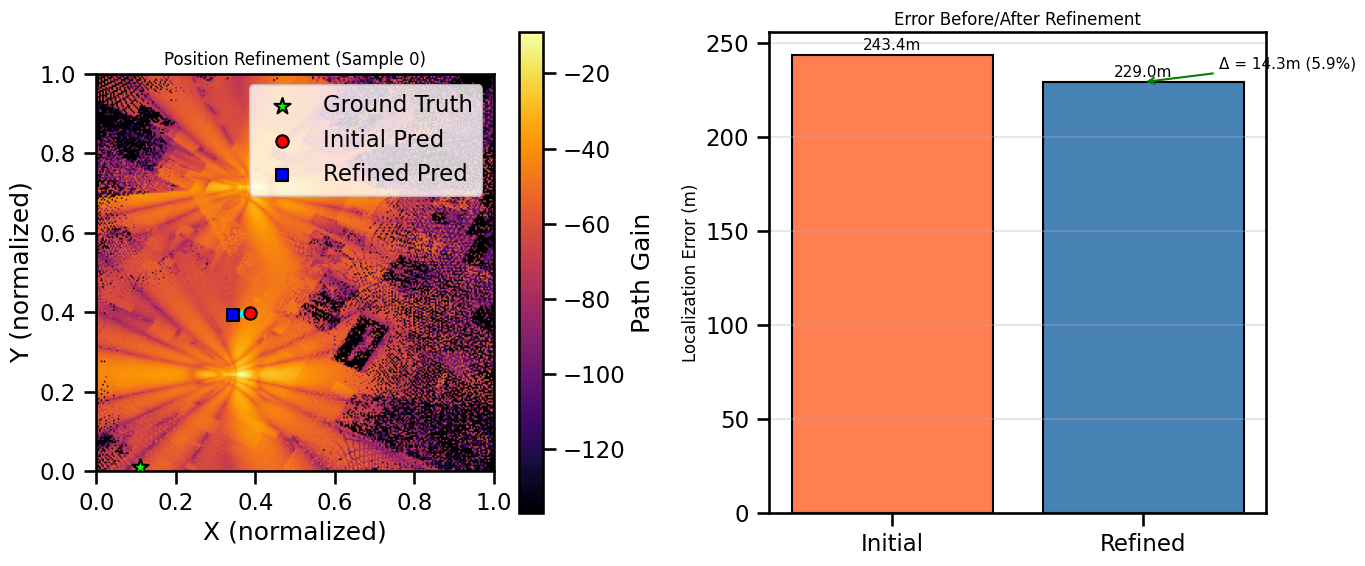

In [43]:
def visualize_refinement(batch, initial_pos, refined_pos, sample_idx=0, scene_extent=512.0):
    """Visualize the position refinement trajectory."""
    true_pos = batch['position'][sample_idx].cpu().numpy()
    init_pos = initial_pos[sample_idx].cpu().numpy()
    ref_pos = refined_pos[sample_idx].cpu().numpy()
    
    radio_map = batch['radio_map'][sample_idx, 0].cpu().numpy()  # Path Gain
    h, w = radio_map.shape
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Visualization on radio map
    ax = axes[0]
    im = ax.imshow(radio_map, cmap='inferno', origin='lower', extent=[0, 1, 0, 1])
    
    # Draw arrow from initial to refined
    ax.annotate('', xy=(ref_pos[0], ref_pos[1]), xytext=(init_pos[0], init_pos[1]),
                arrowprops=dict(arrowstyle='->', color='cyan', lw=2))
    
    ax.scatter(true_pos[0], true_pos[1], c='lime', s=150, marker='*', 
               edgecolors='black', label='Ground Truth', zorder=10)
    ax.scatter(init_pos[0], init_pos[1], c='red', s=80, marker='o', 
               edgecolors='black', label='Initial Pred', zorder=9)
    ax.scatter(ref_pos[0], ref_pos[1], c='blue', s=80, marker='s', 
               edgecolors='black', label='Refined Pred', zorder=9)
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(f'Position Refinement (Sample {sample_idx})', fontsize=12)
    ax.set_xlabel('X (normalized)')
    ax.set_ylabel('Y (normalized)')
    plt.colorbar(im, ax=ax, label='Path Gain')
    ax.legend(loc='upper right')
    
    # 2. Error comparison bar chart
    ax = axes[1]
    
    init_error = np.linalg.norm(init_pos - true_pos) * scene_extent
    ref_error = np.linalg.norm(ref_pos - true_pos) * scene_extent
    
    bars = ax.bar(['Initial', 'Refined'], [init_error, ref_error], 
                  color=['coral', 'steelblue'], edgecolor='black')
    
    # Add improvement annotation
    improvement = init_error - ref_error
    improvement_pct = (improvement / init_error) * 100 if init_error > 0 else 0
    
    ax.annotate(f'Δ = {improvement:.1f}m ({improvement_pct:.1f}%)',
                xy=(1, ref_error), xytext=(1.3, (init_error + ref_error) / 2),
                fontsize=11, ha='left',
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5))
    
    ax.set_ylabel('Localization Error (m)', fontsize=12)
    ax.set_title('Error Before/After Refinement', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Annotate bars
    for bar, val in zip(bars, [init_error, ref_error]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}m', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.show()

visualize_refinement(batch, initial_pos, refined_pos)

## 10. Summary & Complete Loss Formulation

### Total Training Loss

$$\mathcal{L}_{\text{total}} = \underbrace{\lambda_{\text{coarse}} \mathcal{L}_{\text{coarse}}}_{\text{Cross-Entropy}} + \underbrace{\lambda_{\text{fine}} \mathcal{L}_{\text{fine}}}_{\text{Mixture NLL}} + \underbrace{\lambda_{\text{phys}} \mathcal{L}_{\text{phys}}}_{\text{Physics Consistency}}$$

### Key Components

| Component | Description | Purpose |
|-----------|-------------|---------|
| **Coarse Head** | Cross-entropy over grid cells | Identify correct region |
| **Fine Head** | Gaussian Mixture with offsets/uncertainties | Sub-cell refinement |
| **Physics Loss** | MSE on bilinearly sampled radio features | Enforce physics consistency |
| **MAP Refinement** | Gradient descent at inference | Improve low-confidence predictions |

/tmp/ipykernel_1042515/1758373075.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


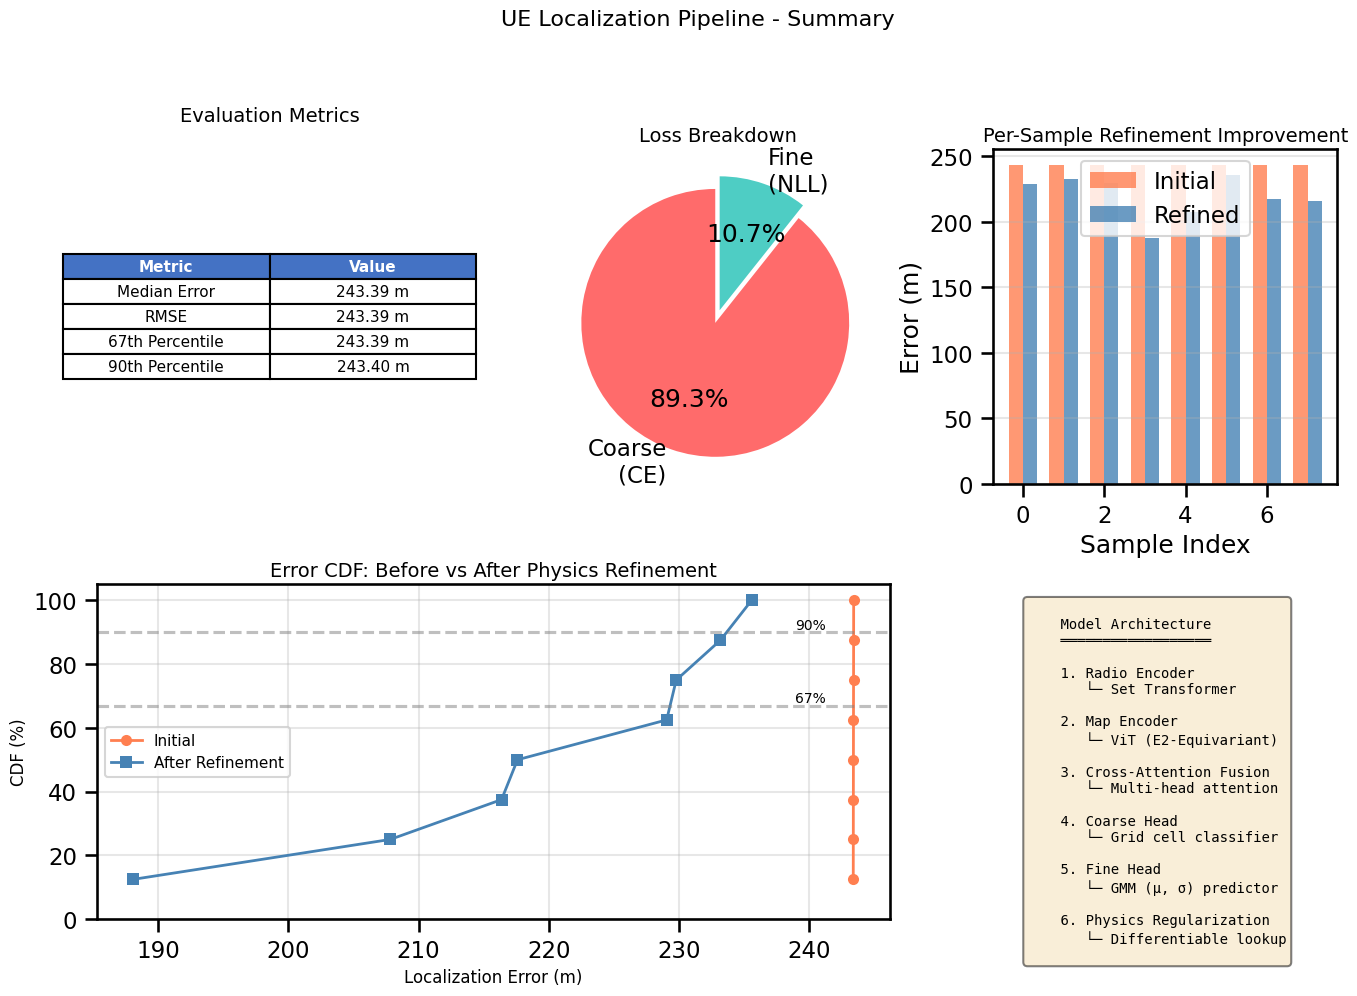

In [44]:
def create_summary_visualization(metrics, losses, initial_errors, refined_errors, scene_extent=512.0):
    """Create a comprehensive summary visualization."""
    
    fig = plt.figure(figsize=(16, 10))
    
    # Create grid layout
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. Metrics table
    ax = fig.add_subplot(gs[0, 0])
    ax.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['Median Error', f"{metrics['Median Error (m)']:.2f} m"],
        ['RMSE', f"{metrics['RMSE (m)']:.2f} m"],
        ['67th Percentile', f"{metrics['67th Percentile (m)']:.2f} m"],
        ['90th Percentile', f"{metrics['90th Percentile (m)']:.2f} m"],
    ]
    
    table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                     colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.5)
    
    # Color header row
    for i in range(2):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(color='white', weight='bold')
    
    ax.set_title('Evaluation Metrics', fontsize=14, pad=20)
    
    # 2. Loss breakdown pie chart
    ax = fig.add_subplot(gs[0, 1])
    loss_values = [losses['coarse_loss'].item(), losses['fine_loss'].item()]
    loss_labels = ['Coarse\n(CE)', 'Fine\n(NLL)']
    colors = ['#FF6B6B', '#4ECDC4']
    
    wedges, texts, autotexts = ax.pie(loss_values, labels=loss_labels, colors=colors,
                                       autopct='%1.1f%%', startangle=90,
                                       explode=(0.05, 0.05))
    ax.set_title('Loss Breakdown', fontsize=14)
    
    # 3. Before/After Refinement comparison
    ax = fig.add_subplot(gs[0, 2])
    
    x = np.arange(len(initial_errors))
    width = 0.35
    
    ax.bar(x - width/2, initial_errors, width, label='Initial', color='coral', alpha=0.8)
    ax.bar(x + width/2, refined_errors, width, label='Refined', color='steelblue', alpha=0.8)
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Error (m)')
    ax.set_title('Per-Sample Refinement Improvement', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 4. CDF comparison
    ax = fig.add_subplot(gs[1, :2])
    
    sorted_init = np.sort(initial_errors)
    sorted_ref = np.sort(refined_errors)
    cdf = np.arange(1, len(sorted_init) + 1) / len(sorted_init) * 100
    
    ax.plot(sorted_init, cdf, 'o-', linewidth=2, label='Initial', color='coral', markersize=8)
    ax.plot(sorted_ref, cdf, 's-', linewidth=2, label='After Refinement', color='steelblue', markersize=8)
    
    ax.axhline(67, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(90, color='gray', linestyle='--', alpha=0.5)
    ax.text(ax.get_xlim()[1] * 0.98, 67, '67%', ha='right', va='bottom', fontsize=10)
    ax.text(ax.get_xlim()[1] * 0.98, 90, '90%', ha='right', va='bottom', fontsize=10)
    
    ax.set_xlabel('Localization Error (m)', fontsize=12)
    ax.set_ylabel('CDF (%)', fontsize=12)
    ax.set_title('Error CDF: Before vs After Physics Refinement', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 105])
    
    # 5. Model architecture summary
    ax = fig.add_subplot(gs[1, 2])
    ax.axis('off')
    
    arch_text = """
    Model Architecture
    ══════════════════
    
    1. Radio Encoder
       └─ Set Transformer
    
    2. Map Encoder
       └─ ViT (E2-Equivariant)
    
    3. Cross-Attention Fusion
       └─ Multi-head attention
    
    4. Coarse Head
       └─ Grid cell classifier
    
    5. Fine Head
       └─ GMM (μ, σ) predictor
    
    6. Physics Regularization
       └─ Differentiable lookup
    """
    
    ax.text(0.1, 0.95, arch_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('UE Localization Pipeline - Summary', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Create final summary
create_summary_visualization(metrics, losses, initial_errors, refined_errors)